In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image    

import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from os import listdir
from os.path import isfile, join
from PIL import Image
import glob


from mpl_toolkits.axes_grid1 import ImageGrid

tf.compat.v1.disable_eager_execution()
seed = 2019
np.random.seed(seed)
%matplotlib inline

In [2]:
dirname = os.getcwd()

train_path = os.path.join("/",dirname, 'OCT2017/train')
train_normal_pth = os.path.join("/",train_path, 'NORMAL')
train_dme_pth = os.path.join("/",train_path, 'DME')
train_drusen_pth = os.path.join("/",train_path, 'DRUSEN')
train_cnv_pth = os.path.join("/",train_path, 'CNV')

test_path = os.path.join("/",dirname, 'OCT2017/test')
test_normal_pth = os.path.join(test_path, 'NORMAL')
test_dme_pth = os.path.join(test_path, 'DME')
test_drusen_pth = os.path.join(test_path, 'DRUSEN')
test_cnv_pth = os.path.join(test_path, 'CNV')

val_path = os.path.join("/",dirname, 'OCT2017/val')
val_normal_pth = os.path.join(val_path, 'NORMAL')
val_dme_pth = os.path.join(val_path, 'DME')
val_drusen_pth = os.path.join(val_path, 'DRUSEN')
val_cnv_pth = os.path.join(val_path, 'CNV')

## Image visualisations : 

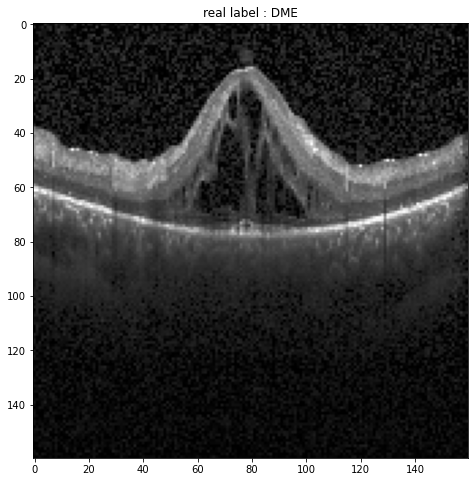

In [3]:
def get_specific_image(path , visualize = False):

    img = image.load_img(path,target_size=(160,160))
    
    if (visualize == True) :
        plt.figure(figsize=(8,8))
        plt.imshow(img)
        label = path.split('/')[-2]
        plt.title('real label : '+ str(label))
    img = np.expand_dims(img,axis=0) /255
    return img 

img_1 = test_path + "/DME/DME-1102486-2.jpeg"    
img = get_specific_image(img_1, visualize = True)



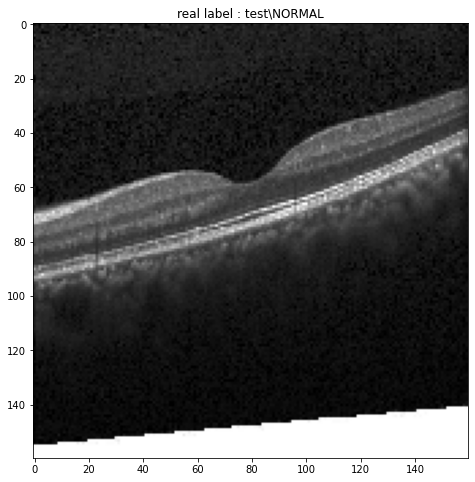

In [4]:
def get_random_image_from_class(class_path, visualize = False) : 
    
    random_file = random.choice([
        x for x in os.listdir(class_path)
        if os.path.isfile(os.path.join(class_path, x))
    ])
    
    path = class_path + '/'+ str(random_file) 
    img = image.load_img(path,target_size=(160,160))
    if (visualize == True) :
        plt.figure(figsize=(8,8))
        plt.imshow(img)
        label = path.split('/')[-2]
        plt.title('real label : '+ str(label))
    
    img = np.expand_dims(img,axis=0) /255
    return img 

img = get_random_image_from_class(test_normal_pth, visualize = True)

### Normal picture : 

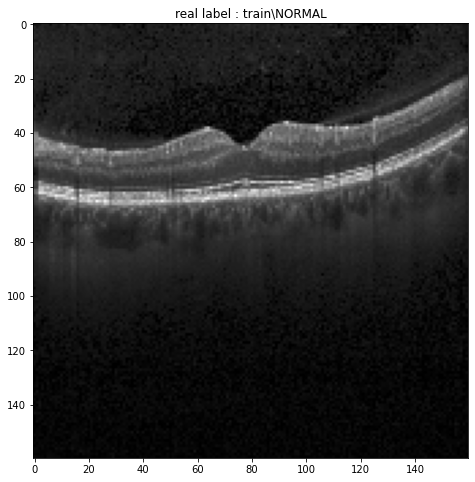

In [5]:
normal_img = get_random_image_from_class(train_normal_pth, visualize = True)

### Diabetic macular Edema : 

Diabetic macular edema (DME) is a complication of diabetes. People with type 1 or type 2 diabetes can develop DME.

DME occurs when excess fluid starts to build up in the macula of the eye. The macula allows us to focus and see fine details. It’s located in the center of the retina, the lining at the back of the eye that’s full of blood vessels.

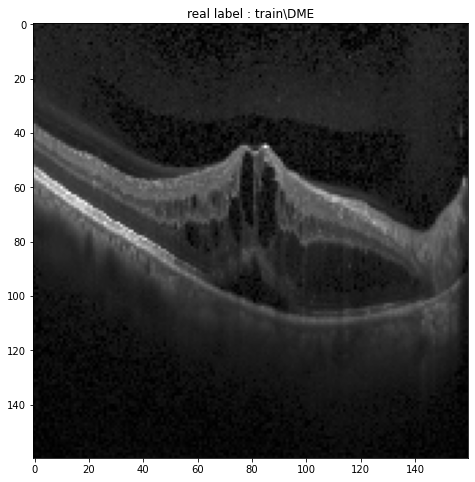

In [6]:
dme_img = get_random_image_from_class(train_dme_pth, visualize = True)

### DRUSEN : 

Drusen are deposits of extracellular waste that accumulate under the retina, between a specialized layer of cells called the retinal pigment epithelium (RPE) and Bruch's membrane, a meshwork of fibrous proteins (mostly collagen). 

The RPE helps maintain the photoreceptors (the light-sensing cells that make up the bulk of the retina), transporting nutrients and wastes between the photoreceptors and the blood vessels that supply them. 

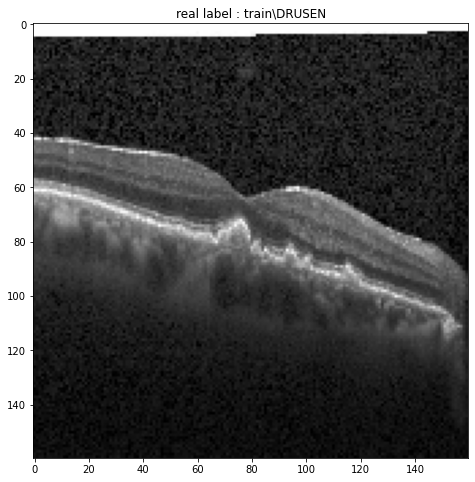

In [7]:
drusen_img = get_random_image_from_class(train_drusen_pth, visualize = True)

### Choroidal Neovascularization (CNV) 

Choroidal neovascularization (CNV) is the creation of new blood vessels in the choroid layer of the eye. Choroidal neovascularization is a common cause of neovascular degenerative maculopathy (i.e. 'wet' macular degeneration) commonly exacerbated by extreme myopia, malignant myopic degeneration, or age-related developments.

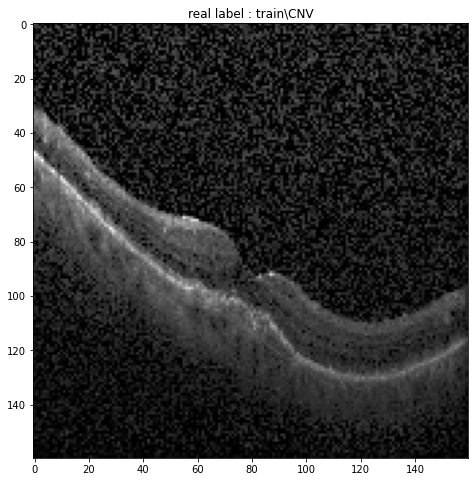

In [8]:
cnv_img = get_random_image_from_class(train_cnv_pth, visualize = True)

### Some informations on the data set : 

In [9]:
input_path = "OCT2017/"
for _set in ['train', 'test', 'val']:
    normal = len(os.listdir(input_path + _set + '/NORMAL'))
    dme = len(os.listdir(input_path + _set + '/DME'))
    drusen = len(os.listdir(input_path + _set + '/DRUSEN'))
    cnv = len(os.listdir(input_path + _set + '/CNV'))
    print('{}, Normal images: {}, DME images: {}, DRUSEN images: {}, CNV images: {}'.format(_set, normal, dme, drusen, cnv))

train, Normal images: 26315, DME images: 11348, DRUSEN images: 8616, CNV images: 37205
test, Normal images: 242, DME images: 242, DRUSEN images: 242, CNV images: 242
val, Normal images: 8, DME images: 8, DRUSEN images: 8, CNV images: 8


### Define the model :  

In [10]:
PARAMS = {'img_dims': 160,
          'epochs': 10,
          'batch_size': 32,
          'optimizer': 'adam',
          'loss': 'categorical_crossentropy',
          'metrics': 'accuracy',
          }

In [258]:
def process_data(img_dims, batch_size):
    
    # Data generation objects
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
        zoom_range = 0.3,
        horizontal_flip = True)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
        directory = train_path, 
        target_size = (img_dims, img_dims), 
        batch_size = batch_size, 
        class_mode = 'categorical', 
        shuffle=True)
    
    test_gen = test_datagen.flow_from_directory(
        directory=test_path, 
        target_size=(img_dims, img_dims), 
        batch_size=batch_size, 
        class_mode='categorical', 
        shuffle=False)
    
    return train_gen, test_gen 


train_gen, test_gen = process_data(PARAMS['img_dims'], PARAMS['batch_size'])

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [12]:
def model(PARAMS) : 
    
    inputs = Input(shape=(PARAMS['img_dims'], PARAMS['img_dims'], 3))

    # First conv block
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Second conv block
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Third conv block
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Fourth conv block
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    # Fifth conv block
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    # FC layer
    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=64, activation='relu')(x)
    x = Dropout(rate=0.3)(x)

    # Output layer
    output = Dense(units=4, activation='softmax')(x)

    # Creating model and compiling
    model = Model(inputs= inputs, outputs=output)
    model.compile(optimizer = PARAMS['optimizer'], loss= PARAMS['loss'], metrics = [PARAMS['metrics']])
    
    # Callbacks
    checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
    lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

    return model 


In [13]:
def model_trainer(model): 
    history = model.fit_generator(
               train_gen, steps_per_epoch=train_gen.samples // PARAMS['batch_size'], 
               epochs=PARAMS['epochs'],
               validation_data=test_gen, 
               validation_steps=test_gen.samples // PARAMS['batch_size'],
               callbacks=[checkpoint, lr_reduce])
    return history 

In [15]:
model1 = model(PARAMS)
model1.load_weights('best_weights.hdf5')

In [16]:
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 160, 160, 16)      448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 160, 160, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 80, 80, 16)        0         
_________________________________________________________________
separable_conv2d_8 (Separabl (None, 80, 80, 32)        688       
_________________________________________________________________
separable_conv2d_9 (Separabl (None, 80, 80, 32)        1344      
_________________________________________________________________
batch_normalization_4 (Batch (None, 80, 80, 32)        128 

We check that we loaded the right model : 

In [24]:
model1.evaluate(test_gen)

[0.027170629954085715, 0.9958678]

In [260]:
predictions = model1.predict(test_gen)
# Get most likely class

In [261]:
predicted_classes = np.argmax(predictions, axis=1)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [306]:
def get_test_labels(): 
    
    test_labels = np.zeros(len(predicted_classes))
    
    for i in range(0,len(test_gen)) : 
        test_labels[32*i : 32*(i+1)] = np.argmax(test_gen[i][1], axis = 1) 
    return test_labels

test_labels = get_test_labels()

Text(0.5, 42.0, 'Predicted label')

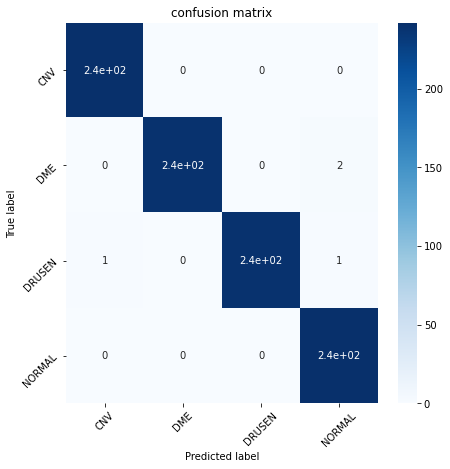

In [307]:
from sklearn.metrics import confusion_matrix
import seaborn as sn


cm = confusion_matrix(test_labels, predicted_classes)

fig, ax = plt.subplots(figsize=(7,7 ))
sn.heatmap(cm,  cmap = plt.cm.Blues, ax = ax, annot = True)
plt.title('confusion matrix')
labels = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
ax.set_xticklabels( labels, rotation=45)
ax.set_yticklabels(labels, rotation=45)
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [308]:
incorrects = np.nonzero(test_labels != predicted_classes)

(array([339, 424, 644, 670], dtype=int64),)

tuple

### Predictions : 

Classes of the data set : 

In [74]:
test_gen.class_indices
classes = {v: k for k, v in test_gen.class_indices.items()}
print('classes of the data set : ', classes) 

classes of the data set :  {0: 'CNV', 1: 'DME', 2: 'DRUSEN', 3: 'NORMAL'}


We take an image from the class DME in the test set, and we check if the model correctly predict its class : 

In [75]:
def prediction(path) :
    
    img_to_predict = get_specific_image(path , visualize = False)
    prediction = np.argmax(model1.predict(img_to_predict), axis = 1)[0]
    return prediction

In [153]:
path = test_path + "/DME/DME-1102486-2.jpeg"    

print('predicted class : ', classes[prediction(path)])
print('real class : ', path.split('/')[-2])

predicted class :  DME
real class :  DME


### Visualisation of filters : 

In [93]:
def get_cnnlayers_positions_in_model(model): 
    positions = []
    i =0
    for layer in model.layers:
        # check for convolutional layer
        if 'conv' not in layer.name:
            i+=1
            continue
        positions.append([i, layer.name, layer.filters])
        i+=1
    return positions

In [94]:
positions = get_cnnlayers_positions_in_model(model1)
positions

[[1, 'conv2d_2', 16],
 [2, 'conv2d_3', 16],
 [4, 'separable_conv2d_8', 32],
 [5, 'separable_conv2d_9', 32],
 [8, 'separable_conv2d_10', 64],
 [9, 'separable_conv2d_11', 64],
 [12, 'separable_conv2d_12', 128],
 [13, 'separable_conv2d_13', 128],
 [17, 'separable_conv2d_14', 256],
 [18, 'separable_conv2d_15', 256]]

In [154]:
def plot_filters(model, i) : 
    
    filters ,bias = model.layers[i].get_weights() 
    
    f_min,f_max=filters.min(),filters.max()
    filters=(filters -f_min)/(f_max-f_min)
    filters.shape

    n_filters,ix = model.layers[i].filters,1
    fig = plt.figure(figsize=(15,15))
   
    for i in range(n_filters):
        f=filters[:,:,:,i]
        for j in range(3):
            ax=plt.subplot(n_filters,3,ix, )
            ax.set_xticks([])
            ax.set_yticks([])
            #Plot filter channel
            plt.imshow(f[:,:,j])
            ix+=1

    plt.legend()
    plt.show()    


In [129]:
a1, a2, a3 = model1.layers[4].get_weights()
a2.shape

(1, 1, 16, 32)

No handles with labels found to put in legend.


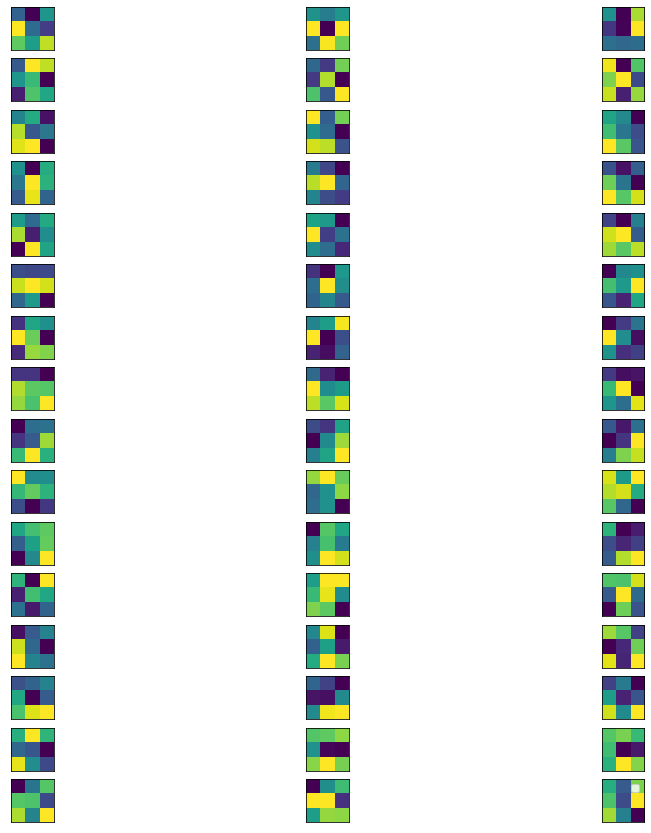

In [163]:
plot_filters(model1, 1)

### Feature Map Visualisation : 

In [166]:
model_feature=Model(inputs=model1.inputs,outputs=model1.layers[1].output)

In [167]:
import numpy as np   
from tensorflow import keras

from tensorflow.keras.preprocessing import image    
 
im1_path=test_path + "/NORMAL/NORMAL-1025847-1.jpeg"

test_image=image.load_img(im1_path,target_size=(160,160))

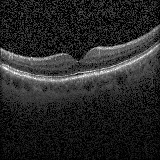

In [168]:
test_image

In [169]:
test_image= np.expand_dims(test_image,axis=0)
test_image = test_image/255

In [170]:
feature_map=model_feature.predict(test_image)

In [171]:
feature_map.shape

(1, 160, 160, 16)

IndexError: index 16 is out of bounds for axis 3 with size 16

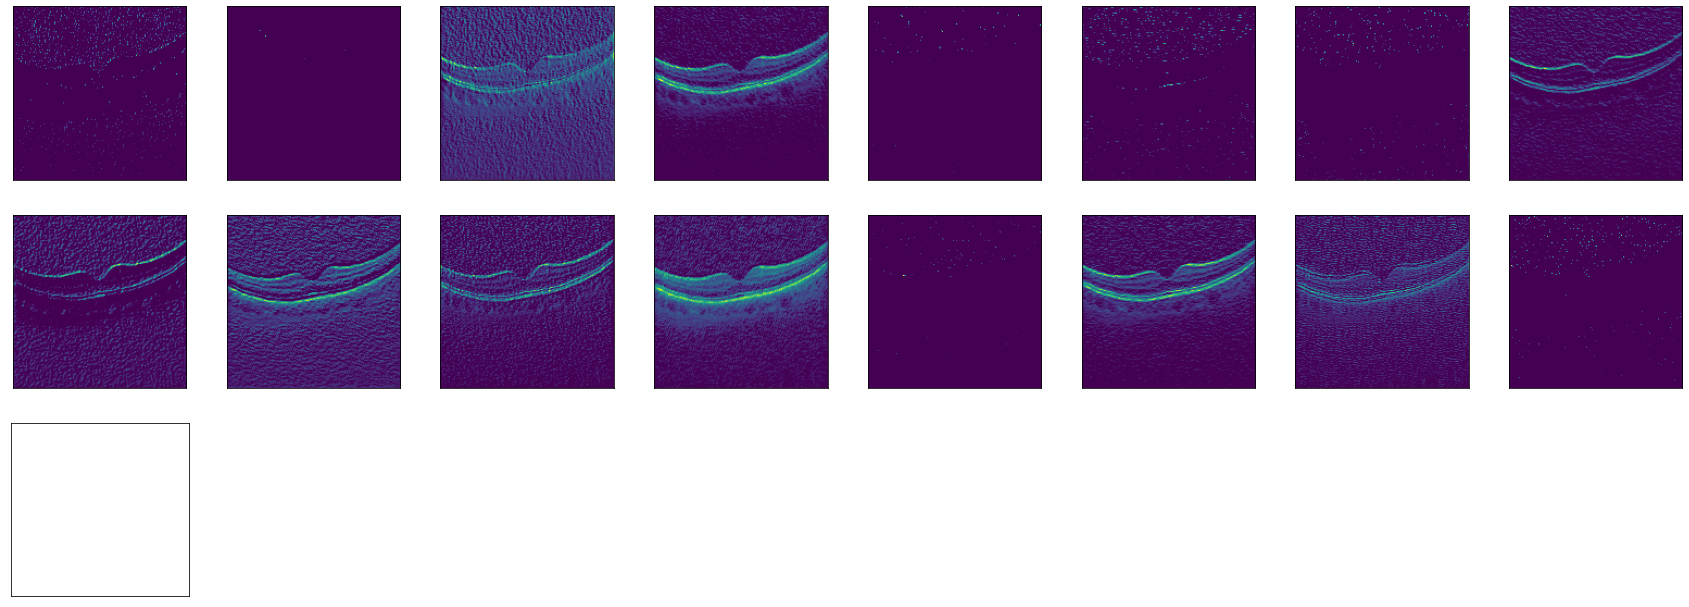

In [175]:
#plot all 32 maps in an 8*4 squares
plt.figure(figsize=(30,30))        
        
square=8
ix=1
for _ in range(8):
    for _ in range(8):
        ax=plt.subplot(square,square,ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_map[0,:,:,ix-1])
        ix+=1
        
plt.show()

In [376]:
im1_path=test_path + "/DME/DME-1102486-2.jpeg"

test_image=image.load_img(im1_path,target_size=(160,160))

In [377]:
test_image
test_image= np.expand_dims(test_image,axis=0)/255

In [378]:

feature_map=model_feature.predict(test_image)
#test_image = test_image/255
model1.predict(test_image)

array([[4.8798802e-06, 9.9999499e-01, 4.7208668e-09, 1.2699232e-07]],
      dtype=float32)

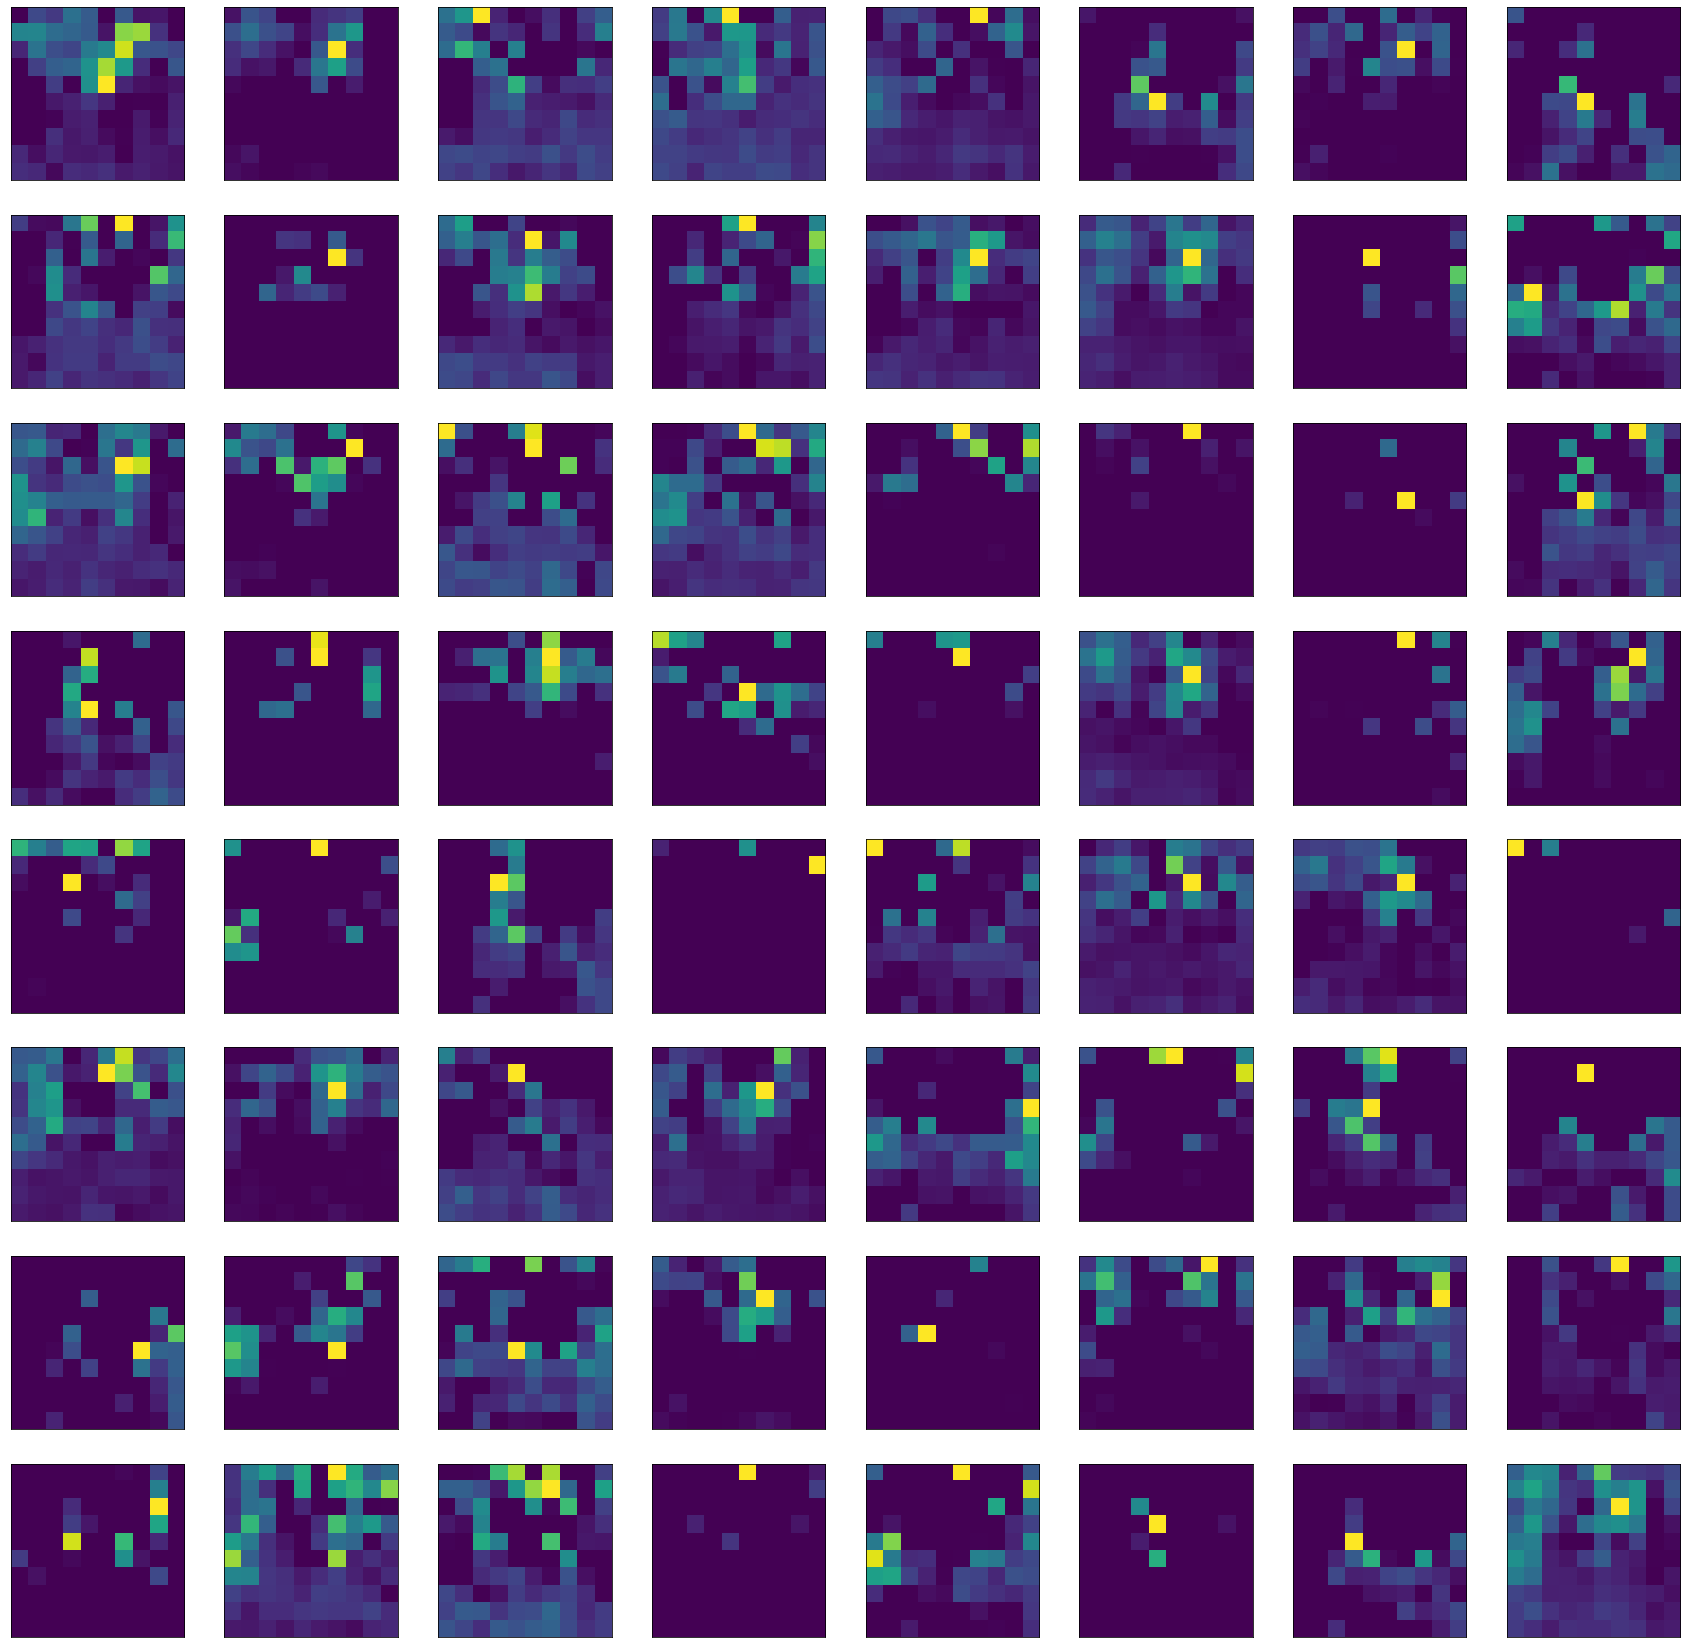

In [497]:
#plot all 32 maps in an 8*4 squares
pyplot.figure(figsize=(30,30))        
        
square=8
ix=1
for _ in range(8):
    for _ in range(8):
        ax=pyplot.subplot(square,square,ix)
        ax.set_xticks([])
        ax.set_yticks([])
        pyplot.imshow(feature_map[0,:,:,ix-1])
        ix+=1
        
pyplot.show()

## HeatMap : 

In [409]:
def heatmap(model, image) : 
    
    predicted = np.argmax(model.predict(image), axis = 1)[0]
    last_conv = model.layers[18]
    grads = K.gradients(model.output[:,predicted],last_conv.output)[0]
    
    pooled_grads = K.mean(grads, axis = (0,1,2))
    iterate = K.function([model.input],[pooled_grads,last_conv.output[0]])
    pooled_grads_value,conv_layer_output = iterate([image])
    
    for i in range(256):
        conv_layer_output[:,:,i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output,axis=-1)
    for x in range(heatmap.shape[0]):
        for y in range(heatmap.shape[1]):
            heatmap[x,y] = np.max(heatmap[x,y],0)
    #heatmap = np.maximum(heatmap,0)
    #heatmap /= np.max(heatmap)
        
    plt.figure(figsize=(10,10))
    upsample = cv2.resize(heatmap, (160,160))
    plt.imshow(image[0])
    plt.imshow(upsample,alpha=0.6)
    plt.title('predicted class : '+ str(classes[predicted]))
    plt.show()
    return  

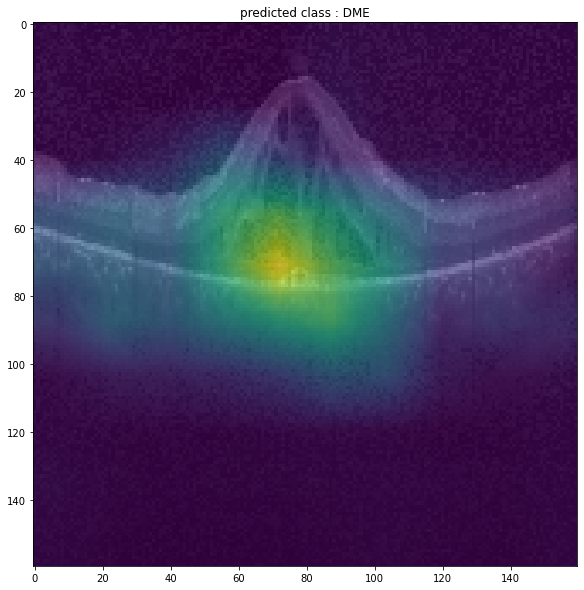

In [399]:
heatmap(model1, test_image)

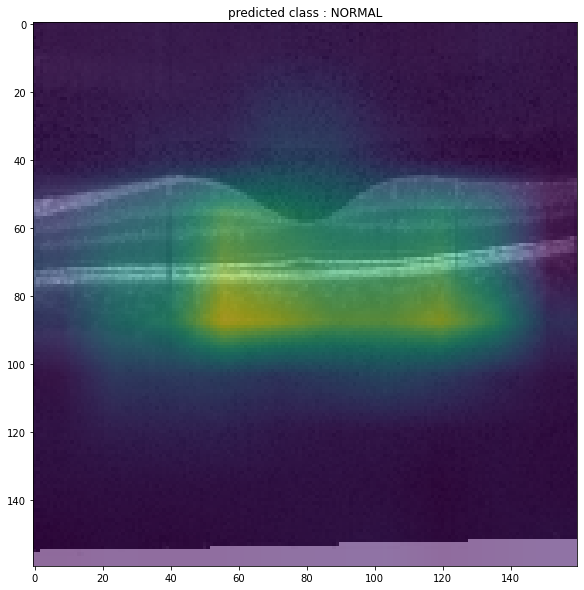

In [414]:
heatmap(model1, get_random_image_from_class(test_normal_pth, visualize = False))

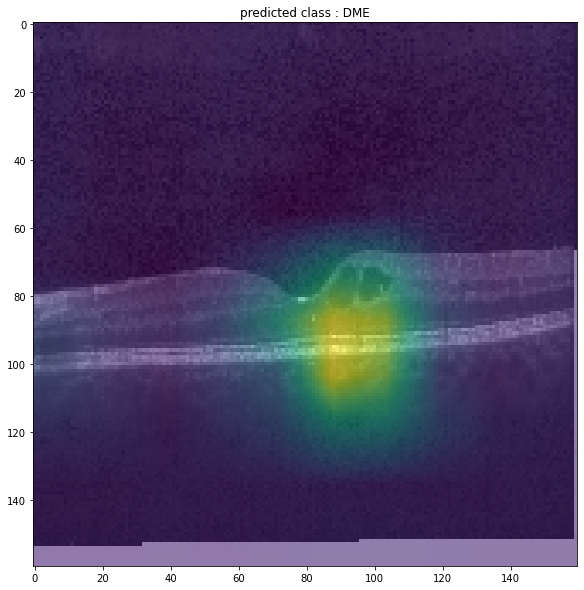

In [415]:
heatmap(model1, get_random_image_from_class(test_dme_pth, visualize = False))

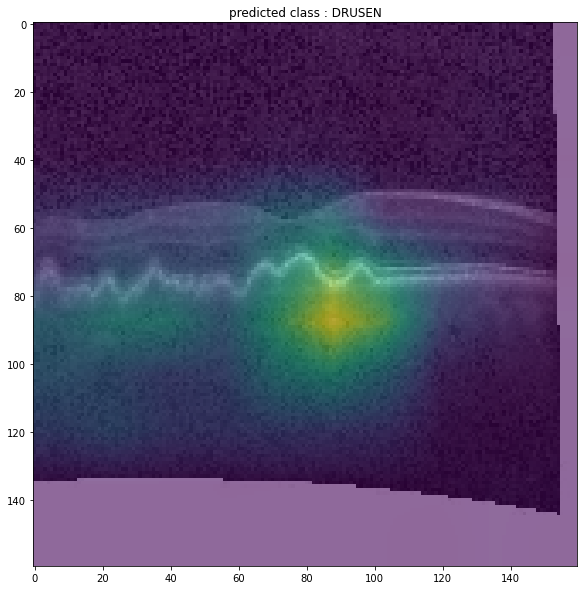

In [416]:
heatmap(model1, get_random_image_from_class(test_drusen_pth, visualize = False))

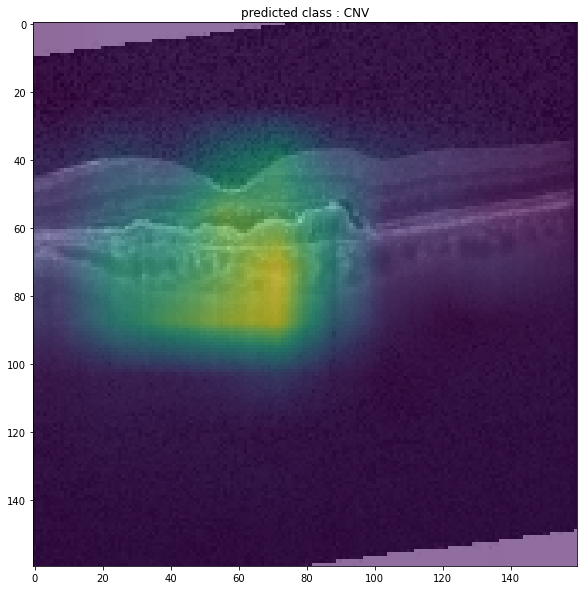

In [418]:
heatmap(model1, get_random_image_from_class(test_cnv_pth, visualize = False))

### Heatmap for misclassified pictures : 

In [394]:
incorrects

(array([339, 424, 644, 670], dtype=int64),)

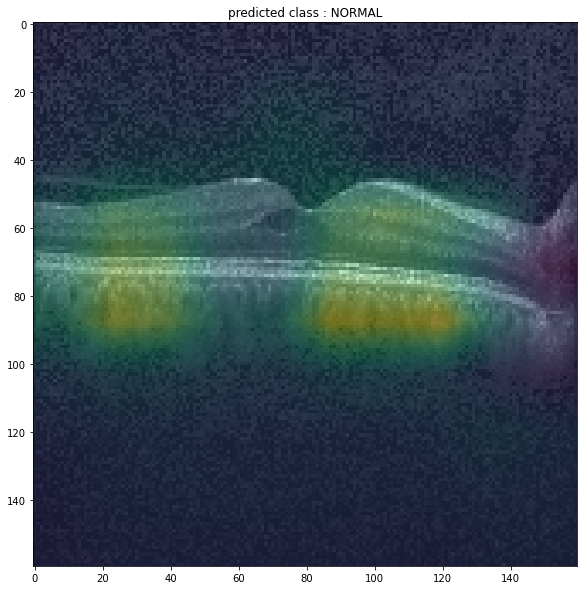

In [406]:
misclassified1 =test_gen[339//32][0][339%32]
misclassified1 = np.expand_dims(misclassified1,axis=0)
heatmap(model1, misclassified1) 
# real : 

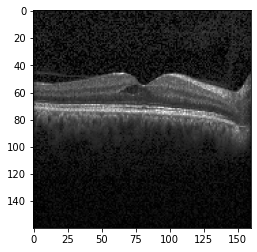

In [421]:
plt.imshow(misclassified1[0])

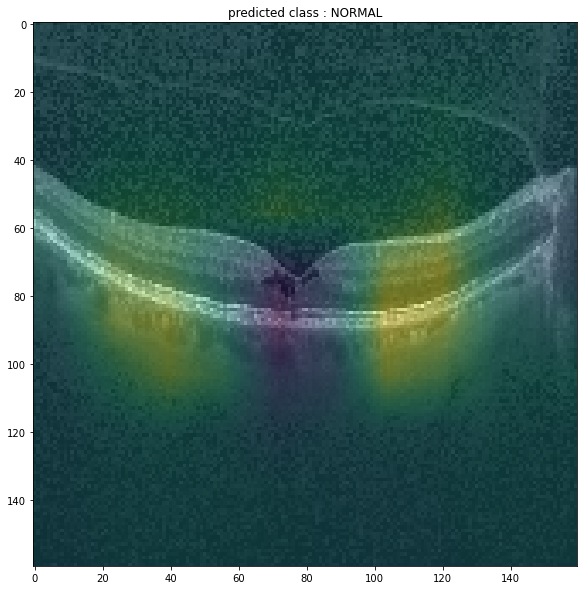

In [407]:
misclassified2 =test_gen[424//32][0][424%32]
misclassified2 = np.expand_dims(misclassified2,axis=0)
heatmap(model1, misclassified2) 
# real : dme 

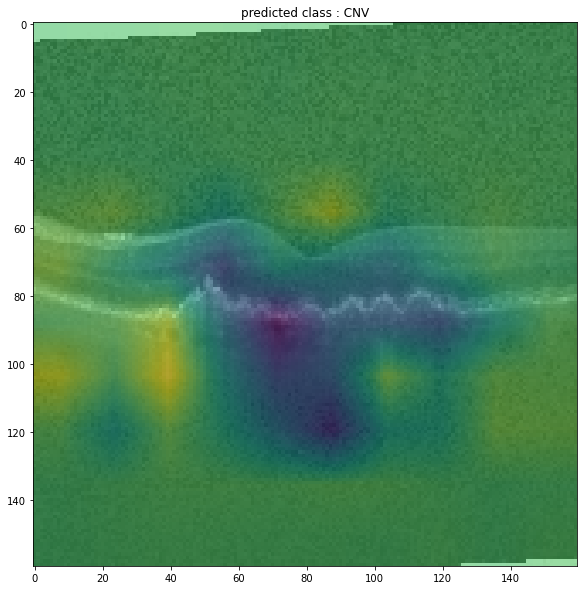

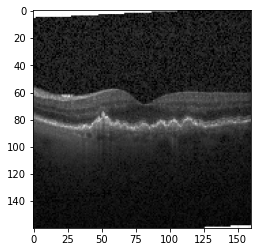

In [411]:
misclassified3 =test_gen[644//32][0][644%32]
misclassified3 = np.expand_dims(misclassified3,axis=0)
heatmap(model1, misclassified3) 
# real : drusen 
plt.imshow(misclassified3[0])

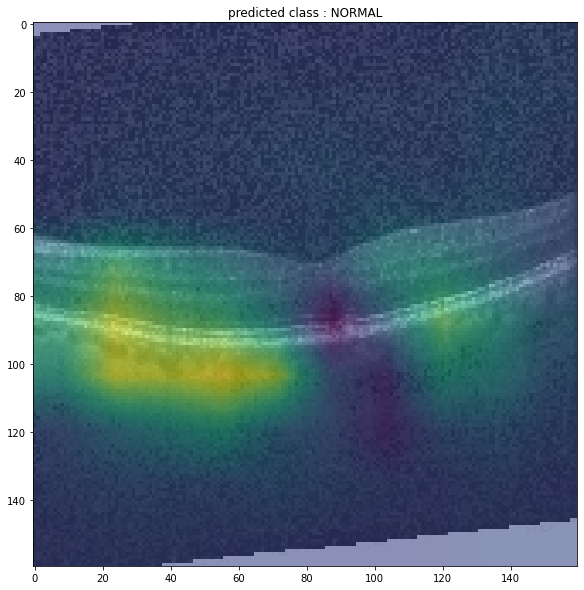

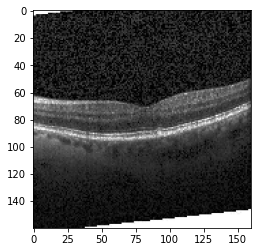

In [413]:
misclassified4 =test_gen[670//32][0][670%32]
misclassified4 = np.expand_dims(misclassified4,axis=0)
heatmap(model1, misclassified4) 
# real : dme 
plt.imshow(misclassified4[0])

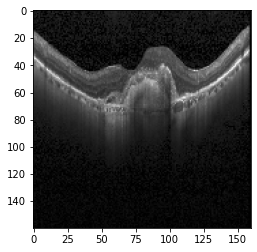

In [423]:
a = get_random_image_from_class(test_cnv_pth, visualize = False)

plt.imshow(a[0])

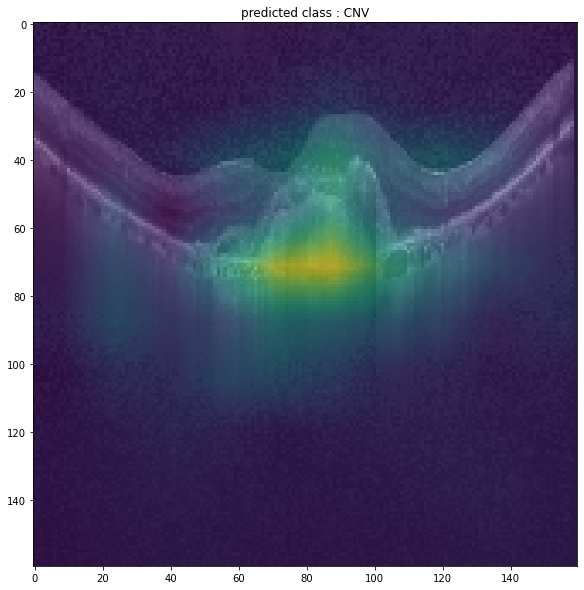

In [424]:
heatmap(model1, a)